In [1]:
import sys
import torch
import torchvision
import datetime
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VGG (block 1)

In [3]:
class VGG1Block(nn.Module):
  def __init__(self):
    super(VGG1Block, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 32, 3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, 2)
    )
    self.classifier = nn.Sequential(
      nn.Linear(32 * 128 * 128, 256),
      nn.ReLU(inplace=True),
      nn.Linear(256, 16),
      nn.ReLU(inplace=True),
      nn.Linear(16, 1)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x


In [5]:
def train_model(model, train_it, epochs=5, lr=0.002):
    global test_it
    import os,shutil
    
    # update these paths before running the function for new model
    if(os.path.exists('logs2/train/model1')): 
        shutil.rmtree('logs2/train/model1')
    train_log_dir = 'logs2/train/model1'
    test_log_dir = 'logs2/test/model1'
    
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)
    optimizer = optim.Adam(model.parameters(), lr)
    criterion = nn.BCEWithLogitsLoss()
    model.to(device)
    model.train()
    itrr = 0
    for epoch in range(epochs):
        loss_val = 0
        for i, (inputs, labels) in enumerate(train_it):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val += loss.item()
            loss.backward()
            optimizer.step()
            accuracy = (outputs>0).eq(labels).sum().item() / labels.size(0)
            with train_summary_writer.as_default():
                tf.summary.scalar('loss', loss.item(), step=itrr)
                tf.summary.scalar('accuracy', accuracy, step=itrr)
            with test_summary_writer.as_default():
                with torch.no_grad():
                    tf.summary.scalar('test accuracy', test_model(model,test_it)[1], step=itrr)
            itrr += 1
        print(f'Epoch {epoch + 1}, Loss: {loss_val / len(train_it)}, {itrr} iterations')
    return model

def test_model(model, test_it):
    loss_func = nn.BCEWithLogitsLoss()
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for inputs, labels in test_it:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            model
            labels = labels.unsqueeze(1).float()
            loss += loss_func(outputs, labels).item()
            predicted = outputs>0
            total += labels.size(0)
            for i in range(labels.size(0)):
                if labels[i] == predicted[i]:
                    correct += 1
    print(f'Accuracy of the network on the test images: {100 * correct / total}%')
    return loss, correct / total


In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)
model = VGG1Block()
xx = datetime.datetime.now()
model = train_model(model, train_it,epochs= 2, lr = 0.0012)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model, test_it)
train_loss, train_accuracy = test_model(model, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 57.5%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 62.5%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 52.5%
Accuracy of the network on the test images: 67.5%
Accuracy of the network on the test images: 55.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%


In [ ]:
%tensorboard

In [22]:
torch.save(model.state_dict(), 'model1.pth')

# VGG (3 block)

In [23]:
class VGG3Block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VGG3Block, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [24]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)
model = VGG3Block()
xx = datetime.datetime.now()
model = train_model(model, train_it, lr = 0.0012)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model, test_it)
train_loss, train_accuracy = test_model(model, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%


In [25]:
torch.save(model.state_dict(), 'model2.pth')

# VGG (3 block with data augmentation)

## data augmentation

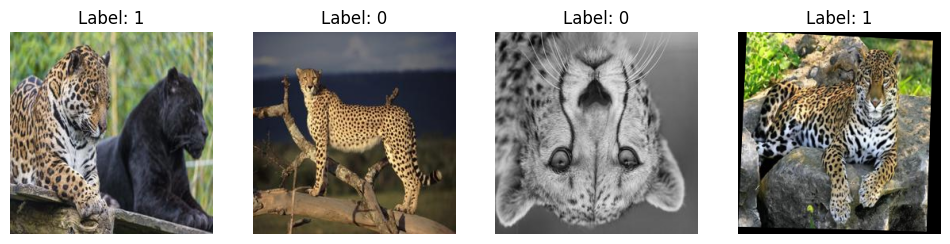

In [27]:
import numpy as np
transform_aug = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
    transforms.RandomGrayscale(0.1),
    transforms.RandomPerspective(0.2, 0.2),
    transforms.RandomVerticalFlip(0.2),
])
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_data_aug = torchvision.datasets.ImageFolder(root='data/train', transform=transform_aug)
train_it_aug = torch.utils.data.DataLoader(train_data_aug, batch_size=4, shuffle=True)
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

import matplotlib.pyplot as plt
images, labels = next(iter(train_it_aug))

# Plot the images
fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
for i, image in enumerate(images):
    image_np = np.transpose(image.numpy(), (1, 2, 0))
    axes[i].imshow(image_np)
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')

plt.show()


In [28]:
model3 = VGG3Block()
xx = datetime.datetime.now()
model3 = train_model(model3, train_it, lr = 0.0009)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model3, test_it)
train_loss, train_accuracy = test_model(model3, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 62.5%
Accuracy of the network on the test images: 67.5%
Accuracy of the network on the test images: 72.5%
Accuracy of the network on the test images: 67.5%


In [54]:
torch.save(model3.state_dict(), 'model3.pth')

Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 1


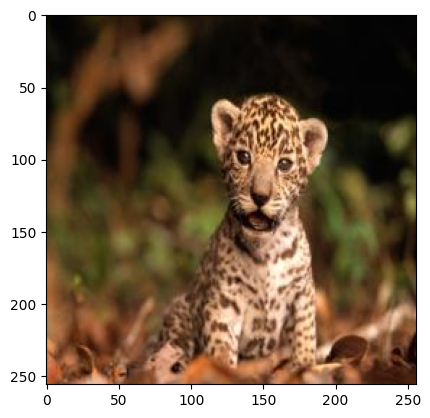

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 1


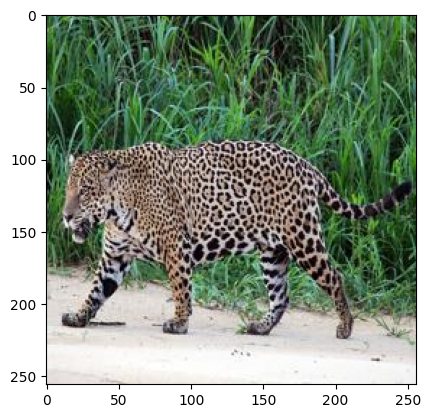

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 1


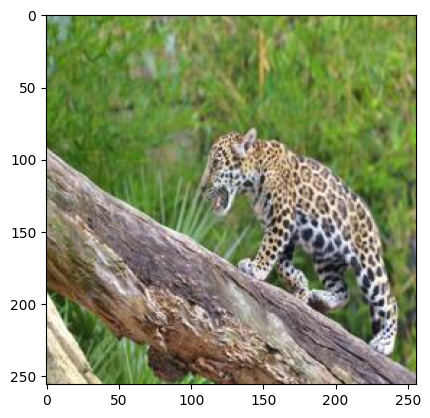

Predicted: 0, True: 1


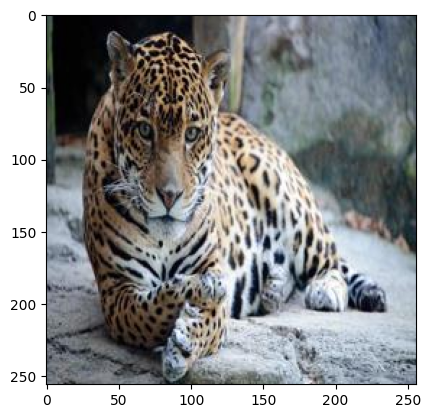

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 1


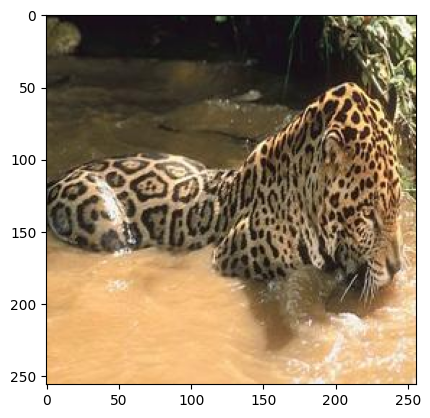

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1


In [13]:
import numpy as np
predicted = []
output = []
train = []
for x,y in test_it:
    train += x.to(device).to('cpu').detach().numpy().tolist()
    predicted += model3(x.to(device)).to('cpu').detach().numpy().tolist()
    output += y
for i in range(len(predicted)):
    ans = int(predicted[i][0]>0)
    print(f'Predicted: {ans}, True: {output[i]}')
    if (ans!=output[i]):
        # Reshape the image
        reshaped_image = np.transpose(train[i], (1, 2, 0))
        # Plot the image
        plt.imshow(reshaped_image)
        plt.show()

torch.Size([1, 3, 256, 256])
Predicted: True
True: tensor([1])


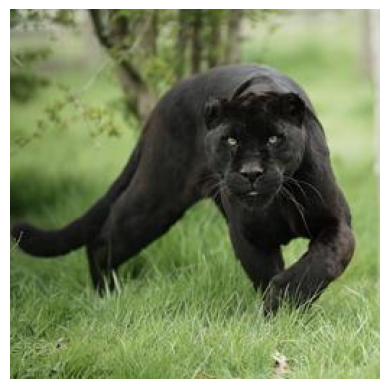

In [6]:
import numpy as np
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
tester = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
tester_it = torch.utils.data.DataLoader(tester, batch_size=1, shuffle=False)
label = 0
itrr = iter(tester_it)
while (label==0):
    image, label = next(itrr)
print(image.shape)
model = VGG3Block()
model_state_dict = torch.load('model3.pth')
model.to(device)
model.eval()
model.load_state_dict(model_state_dict)
output = model(image.to(device))
print(f'Predicted: {(output[0][0]>0)}')
print(f'True: {label}')
import matplotlib.pyplot as plt


image_np = (image.numpy())
image_np = image_np.transpose((2, 3, 1, 0)).squeeze()
# Plot the image
plt.imshow(image_np)
plt.axis('off')
plt.show()


# Transfer learning using VGG16 and tuning only final mlp layers

In [29]:
from torchvision.models import vgg16

class VGG16_tl(nn.Module):
    def __init__(self):
        super(VGG16_tl, self).__init__()
        self.base_model = vgg16(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

In [30]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

In [31]:
model = VGG16_tl()
xx = datetime.datetime.now()
model = train_model(model, train_it, lr = 0.00005)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model, test_it)
train_loss, train_accuracy = test_model(model, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

c:\Users\HITESH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HITESH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\HITESH/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:19<00:00, 28.8MB/s] 


Accuracy of the network on the test images: 85.0%
Accuracy of the network on the test images: 85.0%
Accuracy of the network on the test images: 90.0%
Accuracy of the network on the test images: 90.0%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 95.0%
Accuracy of the network on the test images: 95.0%
Accuracy of the network on the test images: 95.0%
Accuracy of the network on the test images: 92.5%
Accuracy of the network on the test images: 92.5%


In [30]:
torch.save(model, 'model4.pth')

# Transfer learning using VGG16 and tuning all layers

In [32]:
from torchvision.models import vgg16

class VGG16_tl_all(nn.Module):
    def __init__(self):
        super(VGG16_tl_all, self).__init__()
        self.base_model = vgg16(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(1000, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

In [33]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

In [34]:
model = VGG16_tl_all()
xx = datetime.datetime.now()
model = train_model(model, train_it, lr = 0.0001)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model, test_it)
train_loss, train_accuracy = test_model(model, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

c:\Users\HITESH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HITESH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy of the network on the test images: 50.0%
Accuracy of the network on the test images: 52.5%
Accuracy of the network on the test images: 55.0%
Accuracy of the network on the test images: 67.5%
Accuracy of the network on the test images: 87.5%
Accuracy of the network on the test images: 90.0%
Accuracy of the network on the test images: 87.5%
Accuracy of the network on the test images: 87.5%
Accuracy of the network on the test images: 90.0%
Accuracy of the network on the test images: 75.0%
Accuracy of the network on the test images: 80.0%
Accuracy of the network on the test images: 90.0%
Accuracy of the network on the test images: 87.5%
Accuracy of the network on the test images: 87.5%
Accuracy of the network on the test images: 87.5%
Accuracy of the network on the test images: 87.5%
Accuracy of the network on the test images: 90.0%
Accuracy of the network on the test images: 87.5%
Accuracy of the network on the test images: 90.0%
Accuracy of the network on the test images: 92.5%


In [9]:
torch.save(model, 'model5.pth')

# final table

$$
\begin{aligned}
& \text {Table of content}\\
&\begin{array}{cccc}
\hline \hline \text { Model } & \text { Training time } & \text { Training loss } & \text { Training Accuracy } & \text { Testing accuracy } & \text { No. of Model para. } \\
\hline VGG1block & 1:18 & 0.146 & 100 & 95 & 134223009 \\
VGG3Block & 0:31 & 0.0009 & 100 & 90 & 33652065 \\
VGG3Block (data aug) & 0:31 & 0.0001 & 100 & 92.5 & 33652065 \\
VGG16 final MLP & 1:02 & 0.998 & 99.375 & 97.5 & 138617929 (but actually 260385) \\
VGG16 all & 3:30 & 2.62e-05 & 100 & 100 &  138487753\\
\hline
\end{array}
\end{aligned}
$$

In [ ]:
%tensorboard --logdir logs2